In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks, square
from scipy.stats import cauchy, binom, norm
from scipy.optimize import curve_fit, minimize, Bounds
import pandas as pd
import os
from itertools import permutations

In [2]:
def lower_from_arr(arr):
    out = np.zeros((3,3))
    idxs = np.tril_indices(3)
    out[idxs] = arr
    return out

def arr_from_lower(lower):
    idxs = np.tril_indices(3)
    return lower[idxs]

def calc_res(AB0, I, B):
    A = lower_from_arr(AB0[:6])
    B0 = np.vstack(AB0[6:])
    B_vec = np.matmul(A, I) - B0
    B_mag = np.linalg.norm(B_vec, axis=0)
    R_mu = B_mag - B
    return np.dot(R_mu, R_mu)

In [3]:
# try with different starting values, A values etc.!
# also actual data
Is = np.zeros((12,3))
Is[:3,:] = list(set(permutations([5,0,0])))
Is[3:6,:] = list(set(permutations([-5,0,0])))
Is[6:9,:] = list(set(permutations([5,5,0])))
Is[9:, :] = list(set(permutations([-5,-5,0])))
max_t = 12
residuals = np.zeros(max_t)
As = np.zeros((3, 3, max_t))
As[:, :, 0] = np.array([[20, 0, 0], [4, 20, 0], [4, 4, 20]])
B0 = np.array([3, 10, 55]) # background mg-field
A = np.array([[35, 0, 0],[5, -50, 0], [3, 2, 15]])
B0_guess = np.array([10, 10, 10]).T
B0s = np.zeros((3, max_t))
B0s[:, 0] = B0_guess
bounds = Bounds(np.ones(9) * -50, np.ones(9)*60)
for i in range(1, max_t):
    # B is scalar when should be a vector!
    measured_B = np.linalg.norm(np.matmul(A, Is[:i,:].T) + np.atleast_2d(B0).T, axis=0) + norm.rvs(0,0.5)
    AB0_guess = np.append(arr_from_lower(As[:, :, i-1]), B0s[:, i-1])
    # curve_fit would be better than minimize I guess
    opt = minimize(calc_res, x0=AB0_guess, 
                   args=(Is[:i,:].T, measured_B),
                   method='trust-constr',
                   bounds=bounds,
                   hess=lambda x, y, z: np.zeros((len(AB0_guess), len(AB0_guess))))
    Ai = lower_from_arr(opt['x'][:6])
    B0i = opt['x'][6:]
    As[:,:,i] = Ai
    B0s[:, i] = B0i
    residuals[i] = calc_res(opt['x'], Is[:i,:].T, measured_B)

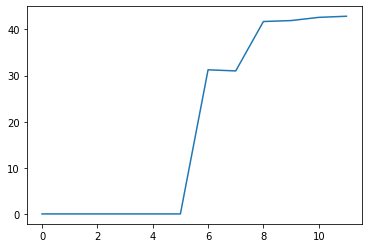

In [4]:
plt.plot(residuals)

In [5]:
with np.printoptions(precision=3, suppress=True):
    print(As[:,:,-1])
    print(A)

[[35.175  0.     0.   ]
 [-5.236 50.336  0.   ]
 [ 4.019  1.235 15.202]]
[[ 35   0   0]
 [  5 -50   0]
 [  3   2  15]]


In [25]:
B0s[:,-1]

array([ -1.47169234,   8.28611499, -49.98907154])

In [26]:
measured_B

array([129.89503327, 193.92184139, 248.14090883, 263.35902594,
       176.70232093,  22.03750465, 289.83659754, 277.34155148,
       231.71342427, 292.23747098, 261.21871593])

In [66]:
ab0 = np.append(A.flatten(), B0)
I = np.ones((3, 10))
calc_res(ab0, I, B[:10])

158686.22467339205

In [72]:
lower_from_arr(arr_from_lower(A))

array([[35.,  0.,  0.],
       [ 5., 35.,  0.],
       [ 5.,  5., 35.]])